Follow the CRISP-DM framework in your analysis (you are not
performing all of the CRISP-DM outline, only the portions relevant to the grading rubric outlined
below).


Create a logistic regression model and a support vector machine model for the
classification task involved with your dataset.  

Assess how well each model performs (use 80/20 training/testing split for your data).

Adjust parameters of the models to make them more
accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel
only is fine to use. 

Adjust parameters of the models to make them more
accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel
only is fine to use. 

 Use the weights from logistic regression to interpret the importance of different
features for each classification task. Explain your interpretation in detail. Why do you think
some variables are more important?

Look at the chosen support vectors for the classification task. Do these provide
any insight into the data? Explain.

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


#Read in data:
ipdata = pd.read_csv("./data/Train_Inpatientdata-1542865627584.csv")
bendata = pd.read_csv("./data/Train_Beneficiarydata-1542865627584.csv")
prodata = pd.read_csv("./data/Train-1542865627584.csv")


#proc_codes = pd.read_csv("./data/CMS27_DESC_LONG_SHORT_SG_092709.csv")
# v27 ICD-9 Procedure Code Data comes from https://www.cms.gov/Medicare/Coding/ICD9ProviderDiagnosticCodes/Downloads/FY2010Diagnosis-ProcedureCodesFullTitles.zip

#diag_codes = pd.read_fwf("./data/V26 I-9 Diagnosis.txt")
# v26 Diag Code Data comes from https://www.cms.gov/Medicare/Coding/ICD9ProviderDiagnosticCodes/Downloads/v27_icd9.zip
# and missing code 7889 comes from https://www.cms.gov/Medicare/Coding/ICD9ProviderDiagnosticCodes/Downloads/v26_icd9.zip



# Merge beneficiary data with inpatient data:
ipdata = ipdata.merge(bendata, left_on='BeneID', right_on='BeneID')

# Merge Provider Data:
ipdata = ipdata.merge(prodata, on='Provider', how='inner')

# Fill NAs
ipdata['DOD'] = ipdata['DOD'].fillna('2199-12-31')
missing_vcols = ['OperatingPhysician', 'OtherPhysician','ClmAdmitDiagnosisCode','DiagnosisGroupCode', 
                 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 
                 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7','ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 
                 'ClmDiagnosisCode_10','ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 
                 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6'] 

ipdata[missing_vcols] = ipdata[missing_vcols].fillna('None')
ipdata['DeductibleAmtPaid'] = ipdata['DeductibleAmtPaid'].fillna(0)



# Convert everythign to string
ipdata = ipdata.applymap(str)

# Convert to usable formats:
timecols = ['ClaimStartDt', 'ClaimEndDt','AdmissionDt', 'DischargeDt', 'DOB','DOD']
numcols = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid','IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt']
catcols = ['PotentialFraud']
intcols = ['ChronicCond_Alzheimer','ChronicCond_Heartfailure','ChronicCond_KidneyDisease','ChronicCond_Cancer','ChronicCond_ObstrPulmonary','ChronicCond_Depression','ChronicCond_Diabetes','ChronicCond_IschemicHeart','ChronicCond_Osteoporasis','ChronicCond_rheumatoidarthritis','ChronicCond_stroke', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov']

ipdata[timecols] = ipdata[timecols].apply(pd.to_datetime)

ipdata['DOD'] = ipdata['DOD'].apply(dt.datetime.toordinal)
ipdata['DOB'] = ipdata['DOB'].apply(dt.datetime.toordinal)
ipdata['ClaimStartDt'] = ipdata['ClaimStartDt'].apply(dt.datetime.toordinal)
ipdata['ClaimEndDt'] = ipdata['ClaimEndDt'].apply(dt.datetime.toordinal)
ipdata['AdmissionDt'] = ipdata['AdmissionDt'].apply(dt.datetime.toordinal)
ipdata['DischargeDt'] = ipdata['DischargeDt'].apply(dt.datetime.toordinal)

ipdata[intcols] = ipdata[intcols].astype(int)

ipdata = ipdata.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)

ipdata = ipdata.replace({'RenalDiseaseIndicator': 'Y'}, 1)


ipdata[numcols] = ipdata[numcols].astype(float)
ipdata[catcols] = ipdata[catcols].astype('category')


ipdata = ipdata.drop(columns=['OPAnnualReimbursementAmt','OPAnnualDeductibleAmt'])

ipdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40474 entries, 0 to 40473
Data columns (total 53 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   BeneID                           40474 non-null  object  
 1   ClaimID                          40474 non-null  object  
 2   ClaimStartDt                     40474 non-null  int64   
 3   ClaimEndDt                       40474 non-null  int64   
 4   Provider                         40474 non-null  object  
 5   InscClaimAmtReimbursed           40474 non-null  float64 
 6   AttendingPhysician               40474 non-null  object  
 7   OperatingPhysician               40474 non-null  object  
 8   OtherPhysician                   40474 non-null  object  
 9   AdmissionDt                      40474 non-null  int64   
 10  ClmAdmitDiagnosisCode            40474 non-null  object  
 11  DeductibleAmtPaid                40474 non-null  float64 
 12  Disc

In [2]:
# One hot encode 
#df = ipdata.sample(frac=0.5, replace=False, random_state=1)
import timeit
start_time = timeit.default_timer()

# Drop ID columns
ipdata = ipdata.drop(columns=['Provider', 'BeneID', 'ClaimID'])

# Onehot encode & convert to sparse matrix
ipdata = pd.get_dummies(ipdata, sparse=True)

# Drop extra response column
ipdata = ipdata.drop(columns='PotentialFraud_No')

X = ipdata.drop(columns='PotentialFraud_Yes')
Y = ipdata["PotentialFraud_Yes"]

# Scale training data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)


# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=86)


total_time = timeit.default_timer() - start_time
print("Total time: ", total_time)

Total time:  161.04053927100085


In [3]:
# Fitting the model takes awhile, let's time it:
import timeit
start_time = timeit.default_timer()

# Logistic Regression
from sklearn.linear_model import LogisticRegression
# This line works, takes about 15 minutes to train
logreg = LogisticRegression(penalty='l2', random_state=86, solver='sag', n_jobs=-1)

# I haven't been able to get this to train w/o crashing.
#logreg = LogisticRegression(penalty='l2', random_state=86, solver='lbfgs', n_jobs=-1)

# fit the model
logreg.fit(X_train,y_train)

fit_time = timeit.default_timer() - start_time
print("Fit time: ", fit_time)


Fit time:  901.0323928419994


Accuracy: 0.864237183446572
Precision: 0.8915689311794645
Recall: 0.8686934023285899
F1: 0.8799825270285028


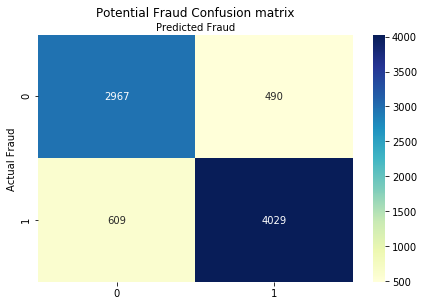

In [23]:
#After fitting, you can play around with predictions to really see the effect of the probability threshold

# Build predictions:
y_pred=logreg.predict_proba(X_test)[:,1] > .515

# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Potential Fraud Confusion matrix', y=1.1)
plt.ylabel('Actual Fraud')
plt.xlabel('Predicted Fraud')

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))



In [6]:
#cross Validation (10 fold CV takes about 2.5 hours)
start_time = timeit.default_timer()
from sklearn.model_selection import cross_val_score, ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=.2, random_state=86)
f1scores = cross_val_score(logreg, X, Y, cv=cv, scoring='f1', n_jobs=-1)
print(f1scores)

cv_time = timeit.default_timer() - start_time
print("CV time: ", cv_time)

[0.87949718 0.88221958 0.88474322 0.88241011 0.87988052 0.88855324
 0.88076588 0.87911612 0.88109921 0.87857827]
CV time:  8483.908526652001
